In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
from utils import load_imagenet_img, make_grayscale, make_black_white, show_mask_on_image, cut_image_with_mask, show_img
from models import load_pretrained_model
%matplotlib inline

def load_ave_data(data_name, path='./data'):
    ave_data_path = os.path.join(path, data_name+'.npy')
    ave_data = np.load(ave_data_path, allow_pickle=True)
    return ave_data

def test_ave_data(ave_data, model, show=False):
    softmax_l = []
    model.eval()
    with torch.no_grad():
        image_tensor = torch.from_numpy(ave_data).type(torch.FloatTensor).cuda()
        logits = model(image_tensor)
        acc = nn.functional.softmax(logits, dim=1)
        acc = acc.cpu().numpy()
        np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
        softmax_l.append(acc)
        if show:
            print(acc)
    return np.array(softmax_l)[0]

def ave_data_max_activation(ave_data, model, steps=5000, learning_rate=1e-3, threshold=1e-6, show=False):
    maximized_ave_data = []
    for i in range(ave_data.shape[0]):  
        target_class = i
        image_tensor = torch.from_numpy(ave_data[i]).type(torch.FloatTensor).unsqueeze(0).cuda()
        image_tensor.requires_grad = True
        image_tensor.retain_grad()
        image_tensor = nn.Parameter(image_tensor)
        
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam([image_tensor], lr=learning_rate, weight_decay=1e-5)
        
        target_class_tensor = torch.from_numpy(np.array([target_class])).to(torch.int64) .cuda()
        
        min_loss = 10000
        maximum = image_tensor.clone()
        for j in range(steps):
            
            logits = model(image_tensor)
            target = torch.zeros_like(logits).cuda()
            loss = loss_fn(logits, target_class_tensor)
            if show:
                if j % (steps // 100) == 0:
                    print('step:{0} loss:{1:8.7f} logit:{2:8.7f}'.format(j, loss.item(), logits[0][target_class].item()))
            if loss < min_loss:
                min_loss = loss
                maximum = image_tensor.clone()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if loss < threshold:
                break
        print('Target class:{0} min loss:{1:8.7f}'.format(i, min_loss.item()))
        maximized_ave_data.append(maximum[0].detach().cpu().numpy())
    return np.array(maximized_ave_data)

def max_activate(model_name_list, ave_data_list, threshold_list, show=False, steps=5000):
    for model_i in range(len(model_name_list)):
        model = load_pretrained_model(model_name_list[model_i].lower())
        model.eval()
        ave_data = load_ave_data(ave_data_list[model_i]+'_ave_data', path='./data')
        
        maximized_ave_data = ave_data_max_activation(ave_data, model, steps=steps, learning_rate=1e-3, threshold=threshold_list[model_i], show=show)
        np.save('./data/maximized_'+model_name_list[model_i].lower()+'_ave_data.npy', maximized_ave_data)
        
        ave_data_result = test_ave_data(ave_data, model)
        plt.figure(figsize=(8, 6))
        sns.heatmap(ave_data_result, annot=True, fmt='.2f')
        plt.title('平均图像分类置信度热力图')
        plt.show()
        
        maximized_result = test_ave_data(maximized_ave_data, model)
        plt.figure(figsize=(8, 6))
        sns.heatmap(maximized_result, annot=True, fmt='.2f')
        plt.title('平均图像分类置信度热力图')
        plt.show()

# topk最小最大平均图置信度测试

Load  AlexNet_mnist


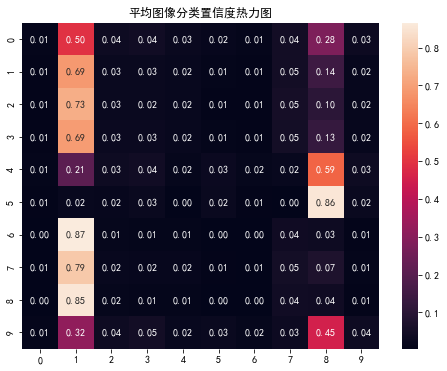

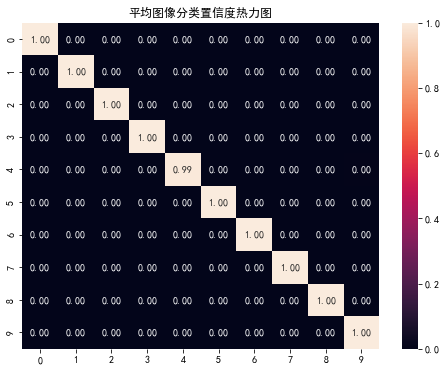

Load  VGG11_mnist


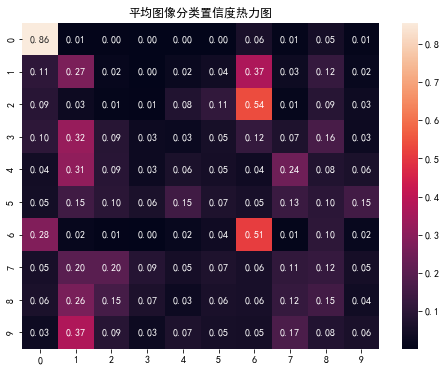

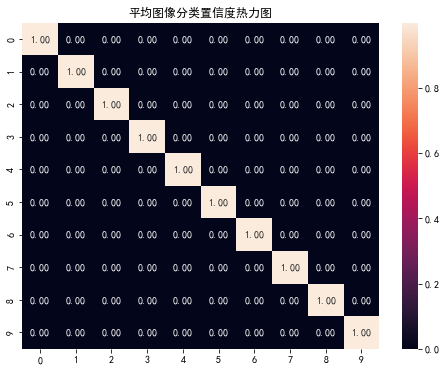

Load  AlexNet_cifar


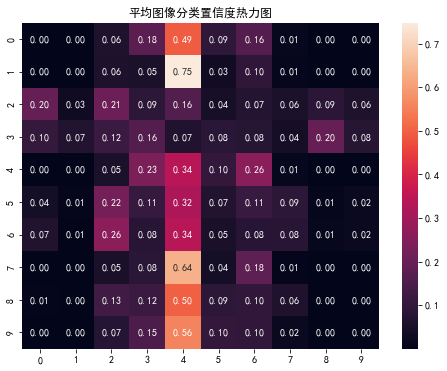

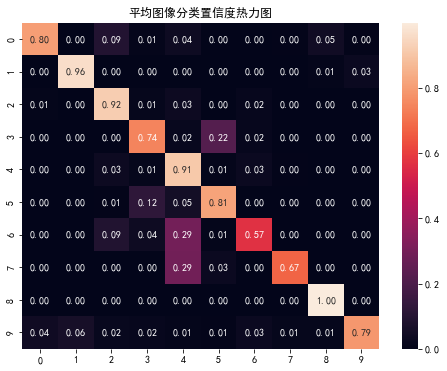

Load  VGG11_cifar


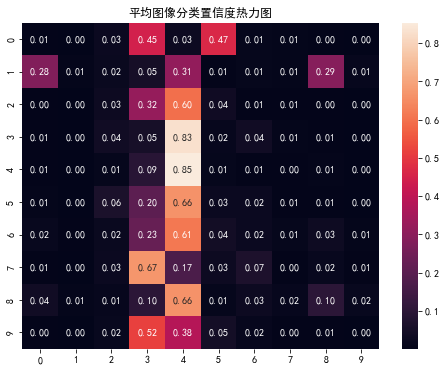

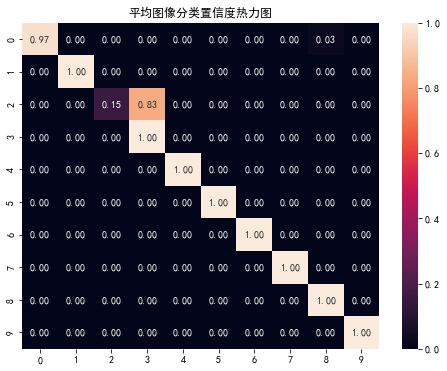

Load  AlexNet_imagenet


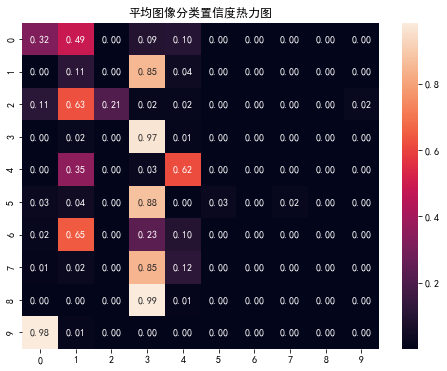

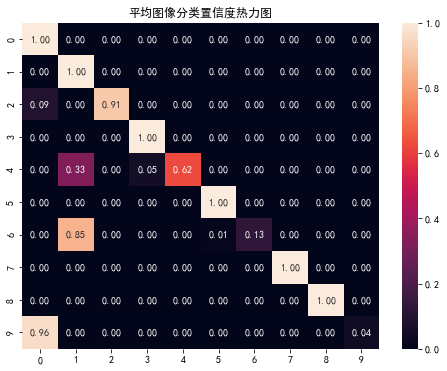

Load  VGG11_imagenet


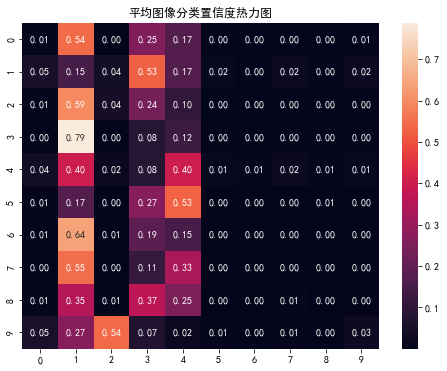

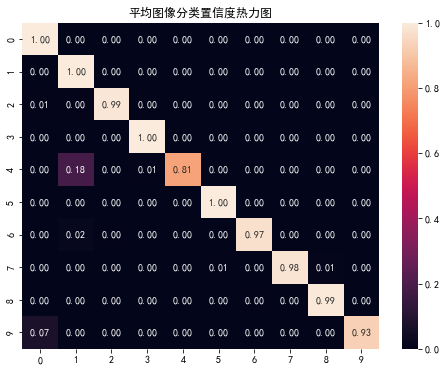

In [7]:
model_name_list = ['AlexNet_mnist','VGG11_mnist',
                   'AlexNet_cifar','VGG11_cifar',
                    'AlexNet_imagenet','VGG11_imagenet']
for model_name in model_name_list:
    model_name = model_name.lower()
    model = load_pretrained_model(model_name)
    model.eval()
    min_ave_data = load_ave_data(data_name=model_name+'_min_ave_data')
    
    min_data_result = test_ave_data(min_ave_data, model)
    plt.figure(figsize=(8, 6))
    sns.heatmap(min_data_result, annot=True, fmt='.2f')
    plt.title('平均图像分类置信度热力图')
    plt.show()
        
    max_ave_data = load_ave_data(data_name=model_name+'_max_ave_data') 
    max_data_result = test_ave_data(max_ave_data, model)
    plt.figure(figsize=(8, 6))
    sns.heatmap(max_data_result, annot=True, fmt='.2f')
    plt.title('平均图像分类置信度热力图')
    plt.show()

# 平均图最大激活优化

Load  AlexNet_imagenet
Target class:0 min loss:0.0000010
Target class:1 min loss:0.0000358
Target class:2 min loss:0.0001173
Target class:3 min loss:0.0000148
Target class:4 min loss:0.0001680
Target class:5 min loss:0.0000577
Target class:6 min loss:0.0002986
Target class:7 min loss:0.0000585
Target class:8 min loss:0.0005317
Target class:9 min loss:0.0001492
[[ 1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.130  0.846  0.000  0.019  0.000  0.002  0.000  0.002  0.000  0.000]
 [ 0.517  0.473  0.003  0.004  0.001  0.000  0.000  0.000  0.000  0.001]
 [ 0.225  0.663  0.007  0.062  0.001  0.033  0.000  0.009  0.000  0.001]
 [ 0.528  0.427  0.000  0.039  0.002  0.002  0.000  0.001  0.000  0.001]
 [ 0.068  0.003  0.018  0.000  0.000  0.745  0.001  0.163  0.001  0.000]
 [ 0.135  0.243  0.014  0.001  0.002  0.506  0.002  0.093  0.002  0.003]
 [ 0.054  0.003  0.007  0.000  0.000  0.838  0.000  0.097  0.001  0.000]
 [ 0.257  0.023  0.021  0.000  0.000  0.567  0.001  0

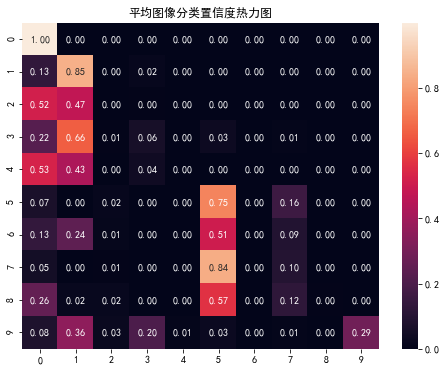

[[ 1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.999  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000]]


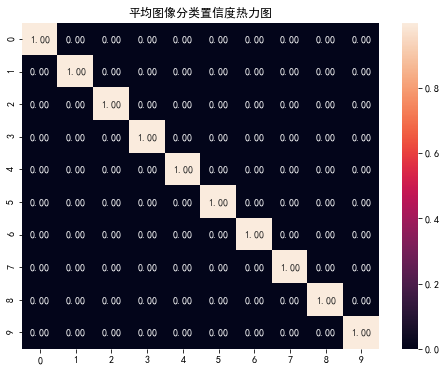

Load  VGG11_imagenet
Target class:0 min loss:0.0005979
Target class:1 min loss:0.0007713
Target class:2 min loss:0.0009673
Target class:3 min loss:0.0007500
Target class:4 min loss:0.0012185
Target class:5 min loss:0.0008865
Target class:6 min loss:0.0008135
Target class:7 min loss:0.0010032
Target class:8 min loss:0.0010122
Target class:9 min loss:0.0026135
[[ 0.993  0.003  0.000  0.000  0.000  0.001  0.000  0.000  0.000  0.003]
 [ 0.051  0.441  0.022  0.341  0.100  0.012  0.008  0.010  0.002  0.015]
 [ 0.275  0.232  0.058  0.307  0.057  0.017  0.003  0.013  0.003  0.035]
 [ 0.015  0.034  0.006  0.913  0.018  0.004  0.001  0.004  0.001  0.004]
 [ 0.052  0.376  0.011  0.331  0.180  0.011  0.007  0.010  0.004  0.018]
 [ 0.196  0.042  0.014  0.198  0.024  0.190  0.013  0.196  0.057  0.068]
 [ 0.065  0.312  0.039  0.173  0.052  0.131  0.067  0.079  0.010  0.072]
 [ 0.162  0.032  0.012  0.116  0.024  0.237  0.014  0.281  0.056  0.066]
 [ 0.118  0.130  0.030  0.286  0.055  0.099  0.019  0.1

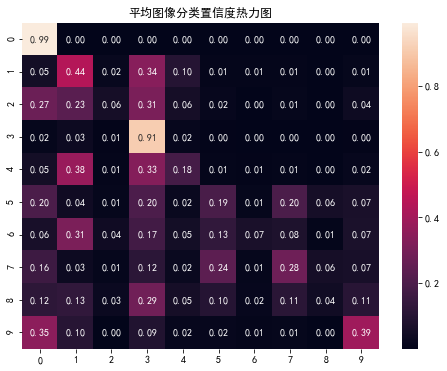

[[ 0.999  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.999  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.999  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.999  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.001  0.000  0.000  0.999  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.001  0.000  0.000  0.000  0.999  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.999  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.999  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.999  0.000]
 [ 0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.997]]


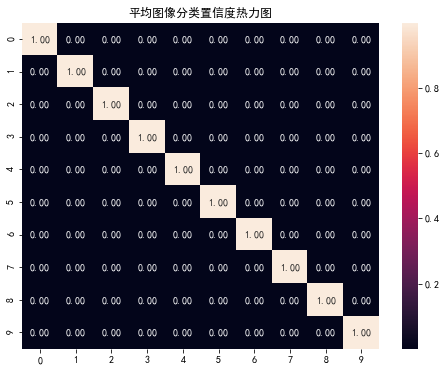

Load  ResNet18_imagenet
Target class:0 min loss:0.0000590
Target class:1 min loss:0.0000993
Target class:2 min loss:0.0001125
Target class:3 min loss:0.0000457
Target class:4 min loss:0.0001059
Target class:5 min loss:0.0000371
Target class:6 min loss:0.0001607
Target class:7 min loss:0.0000752
Target class:8 min loss:0.0000873
Target class:9 min loss:0.0003019
[[ 0.274  0.146  0.089  0.034  0.238  0.048  0.001  0.086  0.006  0.076]
 [ 0.079  0.044  0.002  0.126  0.079  0.347  0.001  0.199  0.003  0.120]
 [ 0.175  0.193  0.019  0.060  0.217  0.067  0.001  0.116  0.009  0.142]
 [ 0.030  0.210  0.003  0.229  0.187  0.135  0.002  0.146  0.008  0.050]
 [ 0.003  0.011  0.000  0.009  0.009  0.859  0.001  0.084  0.015  0.008]
 [ 0.015  0.205  0.013  0.024  0.026  0.572  0.005  0.103  0.011  0.027]
 [ 0.022  0.182  0.002  0.092  0.157  0.350  0.002  0.112  0.015  0.066]
 [ 0.014  0.150  0.015  0.014  0.017  0.649  0.004  0.107  0.007  0.021]
 [ 0.008  0.044  0.002  0.023  0.020  0.802  0.002  

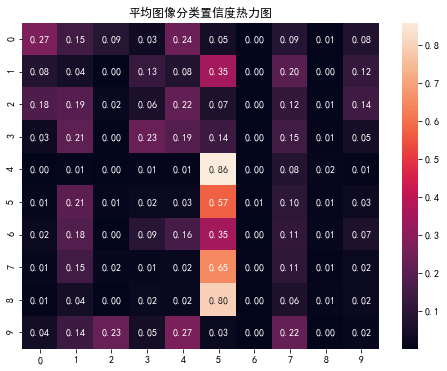

[[ 1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000]]


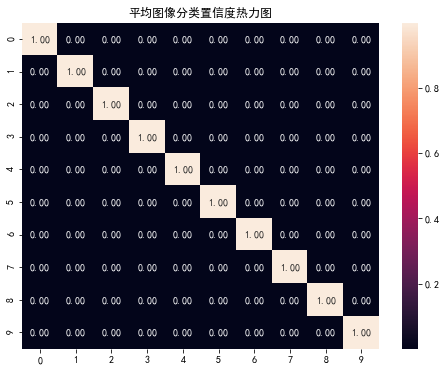

Load  AlexNet_cifar
Target class:0 min loss:0.0000106
Target class:1 min loss:0.0000075
Target class:2 min loss:0.0000231
Target class:3 min loss:0.0000317
Target class:4 min loss:0.0000027
Target class:5 min loss:0.0000083
Target class:6 min loss:0.0000061
Target class:7 min loss:0.0000199
Target class:8 min loss:0.0000014
Target class:9 min loss:0.0000172
[[ 0.138  0.062  0.014  0.018  0.014  0.006  0.007  0.002  0.684  0.056]
 [ 0.112  0.111  0.082  0.124  0.058  0.060  0.073  0.030  0.254  0.095]
 [ 0.008  0.003  0.130  0.240  0.277  0.154  0.130  0.049  0.005  0.004]
 [ 0.009  0.005  0.111  0.306  0.196  0.188  0.125  0.048  0.007  0.005]
 [ 0.004  0.001  0.130  0.117  0.511  0.075  0.128  0.032  0.001  0.001]
 [ 0.005  0.002  0.106  0.276  0.265  0.182  0.115  0.044  0.003  0.003]
 [ 0.005  0.001  0.154  0.101  0.480  0.056  0.173  0.026  0.001  0.002]
 [ 0.011  0.003  0.156  0.142  0.390  0.092  0.139  0.057  0.004  0.006]
 [ 0.104  0.037  0.006  0.009  0.007  0.002  0.003  0.00

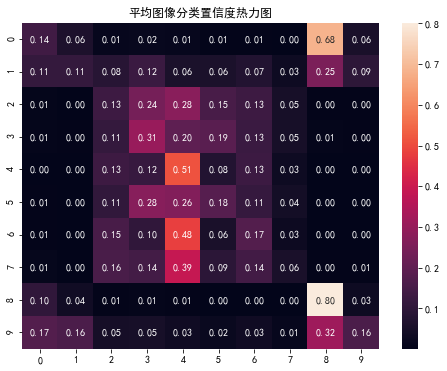

[[ 1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000]]


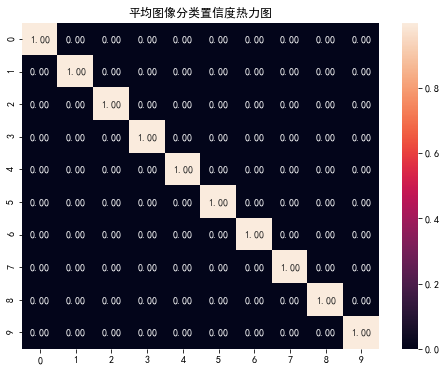

Load  VGG11_cifar
Target class:0 min loss:0.0000036
Target class:1 min loss:0.0000010
Target class:2 min loss:0.0000039
Target class:3 min loss:0.0000020
Target class:4 min loss:0.0000021
Target class:5 min loss:0.0000014
Target class:6 min loss:0.0000010
Target class:7 min loss:0.0000019
Target class:8 min loss:0.0000010
Target class:9 min loss:0.0000011
[[ 0.050  0.006  0.016  0.031  0.023  0.004  0.007  0.003  0.847  0.013]
 [ 0.049  0.013  0.023  0.110  0.178  0.012  0.051  0.008  0.524  0.033]
 [ 0.005  0.002  0.085  0.514  0.161  0.026  0.191  0.003  0.010  0.003]
 [ 0.007  0.002  0.046  0.638  0.198  0.026  0.060  0.005  0.014  0.005]
 [ 0.004  0.002  0.077  0.510  0.228  0.030  0.139  0.003  0.006  0.002]
 [ 0.005  0.001  0.045  0.797  0.094  0.025  0.019  0.004  0.008  0.002]
 [ 0.004  0.002  0.063  0.414  0.323  0.029  0.151  0.004  0.006  0.003]
 [ 0.013  0.004  0.064  0.432  0.276  0.027  0.125  0.006  0.043  0.008]
 [ 0.030  0.002  0.003  0.003  0.003  0.001  0.001  0.001 

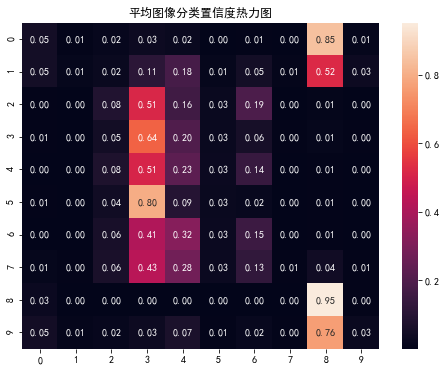

[[ 1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000]]


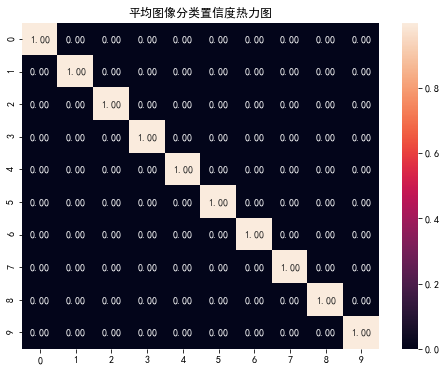

Load  ResNet18_cifar
Target class:0 min loss:0.0000107
Target class:1 min loss:0.0000103
Target class:2 min loss:0.0000057
Target class:3 min loss:0.0000108
Target class:4 min loss:0.0000110
Target class:5 min loss:0.0000242
Target class:6 min loss:0.0000010
Target class:7 min loss:0.0000172
Target class:8 min loss:0.0000014
Target class:9 min loss:0.0000106
[[ 0.321  0.003  0.014  0.019  0.010  0.002  0.003  0.001  0.625  0.003]
 [ 0.282  0.003  0.024  0.089  0.050  0.008  0.014  0.002  0.522  0.005]
 [ 0.253  0.003  0.128  0.209  0.187  0.024  0.063  0.005  0.122  0.005]
 [ 0.488  0.005  0.039  0.138  0.034  0.010  0.033  0.002  0.246  0.005]
 [ 0.278  0.003  0.156  0.154  0.201  0.018  0.119  0.004  0.064  0.004]
 [ 0.470  0.005  0.063  0.143  0.078  0.016  0.051  0.003  0.167  0.005]
 [ 0.387  0.004  0.114  0.154  0.106  0.014  0.118  0.003  0.096  0.003]
 [ 0.207  0.004  0.031  0.120  0.191  0.019  0.014  0.006  0.398  0.009]
 [ 0.126  0.001  0.004  0.005  0.007  0.001  0.001  0.0

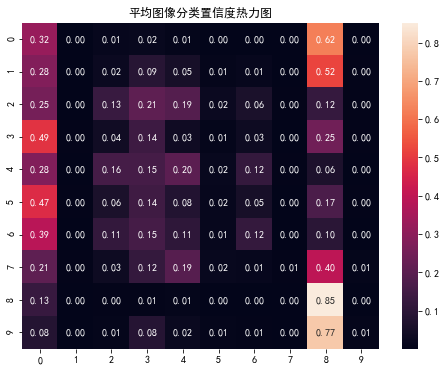

[[ 1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000]]


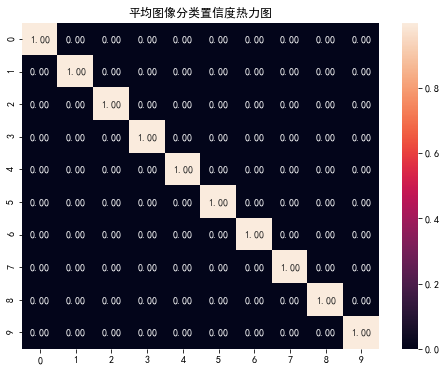

Load  AlexNet_mnist
Target class:0 min loss:0.0000010
Target class:1 min loss:0.0000010
Target class:2 min loss:0.0000010
Target class:3 min loss:0.0000010
Target class:4 min loss:0.0000010
Target class:5 min loss:0.0000010
Target class:6 min loss:0.0000010
Target class:7 min loss:0.0000010
Target class:8 min loss:0.0000012
Target class:9 min loss:0.0000044
[[ 0.009  0.685  0.028  0.029  0.024  0.012  0.009  0.051  0.132  0.021]
 [ 0.001  0.971  0.004  0.003  0.002  0.001  0.001  0.013  0.005  0.001]
 [ 0.010  0.536  0.032  0.035  0.022  0.017  0.012  0.041  0.269  0.026]
 [ 0.007  0.767  0.022  0.022  0.021  0.008  0.007  0.050  0.081  0.015]
 [ 0.011  0.294  0.033  0.040  0.018  0.024  0.014  0.029  0.504  0.032]
 [ 0.011  0.436  0.034  0.039  0.021  0.021  0.013  0.037  0.358  0.030]
 [ 0.012  0.514  0.035  0.039  0.024  0.019  0.013  0.045  0.270  0.029]
 [ 0.011  0.596  0.033  0.034  0.027  0.016  0.012  0.054  0.189  0.027]
 [ 0.004  0.871  0.015  0.012  0.013  0.004  0.004  0.04

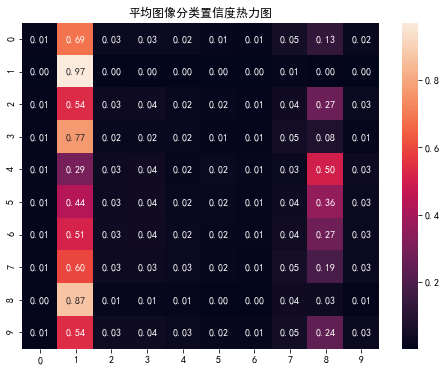

[[ 1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000]]


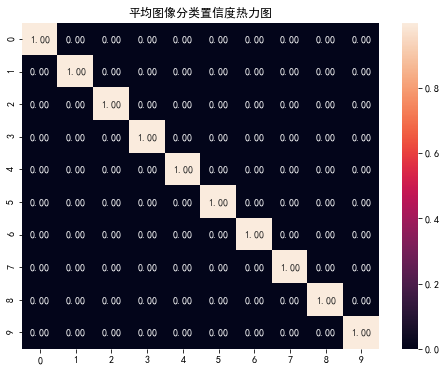

Load  VGG11_mnist
Target class:0 min loss:0.0000056
Target class:1 min loss:0.0000050
Target class:2 min loss:0.0000149
Target class:3 min loss:0.0000114
Target class:4 min loss:0.0000052
Target class:5 min loss:0.0000147
Target class:6 min loss:0.0000064
Target class:7 min loss:0.0000045
Target class:8 min loss:0.0000132
Target class:9 min loss:0.0000563
[[ 0.998  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.001  0.000]
 [ 0.000  0.999  0.000  0.000  0.000  0.000  0.001  0.000  0.000  0.000]
 [ 0.001  0.048  0.788  0.038  0.003  0.005  0.001  0.076  0.031  0.009]
 [ 0.000  0.000  0.003  0.923  0.000  0.028  0.000  0.000  0.035  0.011]
 [ 0.000  0.001  0.000  0.000  0.949  0.007  0.005  0.002  0.002  0.034]
 [ 0.000  0.004  0.005  0.039  0.076  0.666  0.037  0.006  0.050  0.116]
 [ 0.013  0.000  0.000  0.000  0.002  0.009  0.966  0.000  0.009  0.000]
 [ 0.001  0.003  0.002  0.000  0.001  0.000  0.000  0.987  0.001  0.005]
 [ 0.085  0.036  0.064  0.057  0.003  0.055  0.075  0.019 

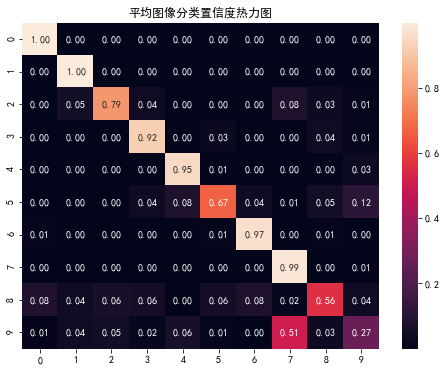

[[ 1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000]]


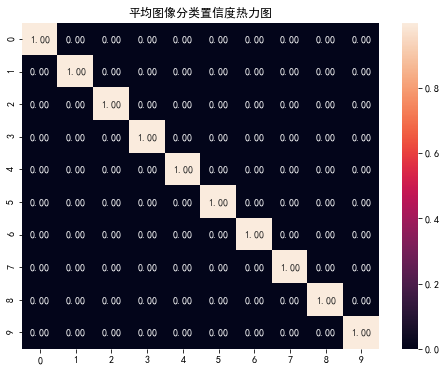

Load  ResNet18_mnist
Target class:0 min loss:0.0000031
Target class:1 min loss:0.0000048
Target class:2 min loss:0.0000019
Target class:3 min loss:0.0000018
Target class:4 min loss:0.0000015
Target class:5 min loss:0.0000035
Target class:6 min loss:0.0000032
Target class:7 min loss:0.0000027
Target class:8 min loss:0.0000020
Target class:9 min loss:0.0000029
[[ 1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.999  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.001  0.996  0.000  0.002  0.000  0.001  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.001  0.000  0.000  0.001  0.000  0.993  0.001  0.001  0.001  0.001]
 [ 0.001  0.000  0.000  0.000  0.000  0.000  0.998  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.0

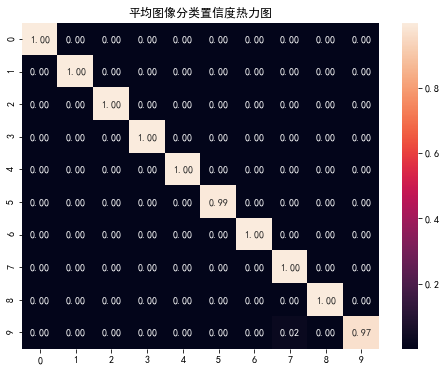

[[ 1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000]
 [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000]]


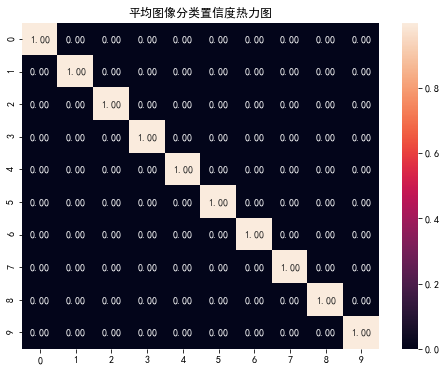

In [2]:
model_name_list = ['AlexNet_imagenet','VGG11_imagenet','ResNet18_imagenet',
                   'AlexNet_cifar','VGG11_cifar','ResNet18_cifar',
                  'AlexNet_mnist','VGG11_mnist','ResNet18_mnist']
ave_data_list = ['imagenet']*3+['cifar']*3+['mnist']*3
threshold_list = [1e-6, 1e-6, 1e-6]*3

max_activate(model_name_list, ave_data_list, threshold_list, steps=5000)

Load  AlexNet_imagenet


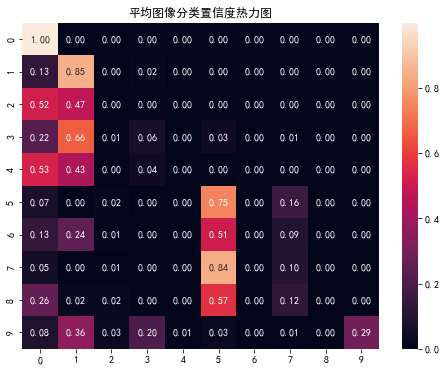

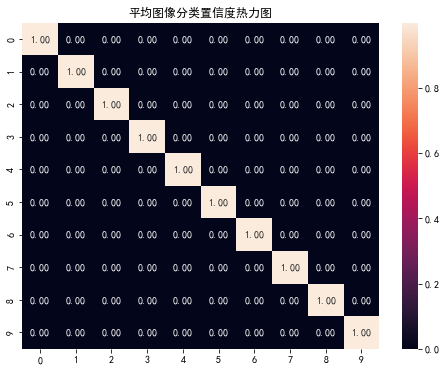

Load  VGG11_imagenet


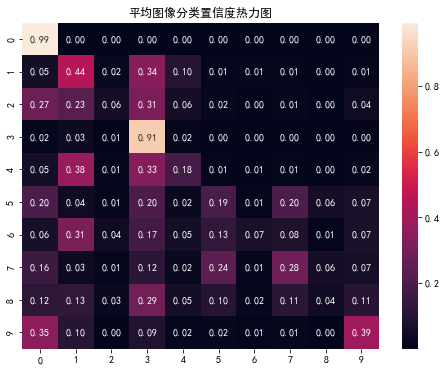

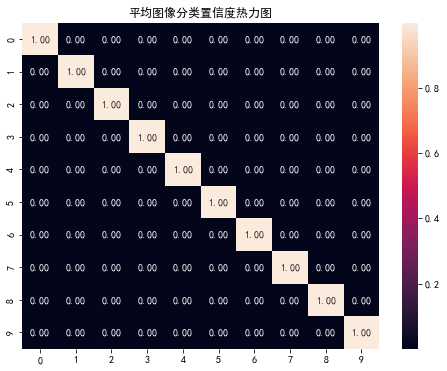

Load  ResNet18_imagenet


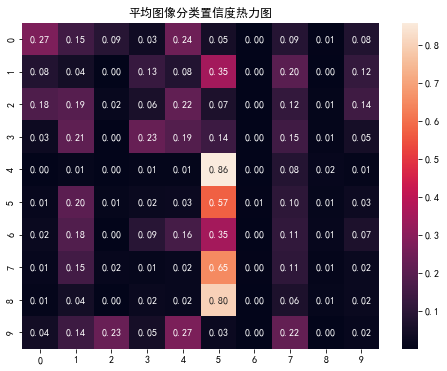

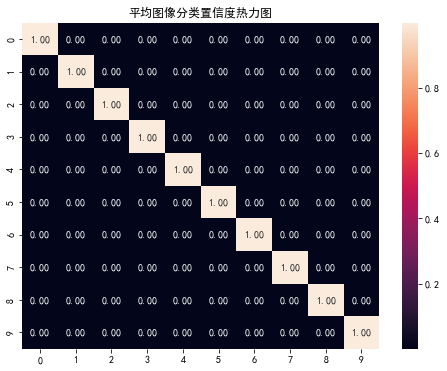

Load  AlexNet_cifar


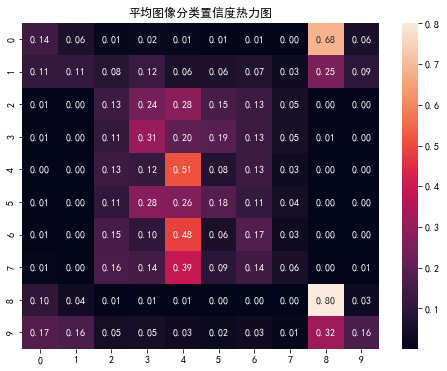

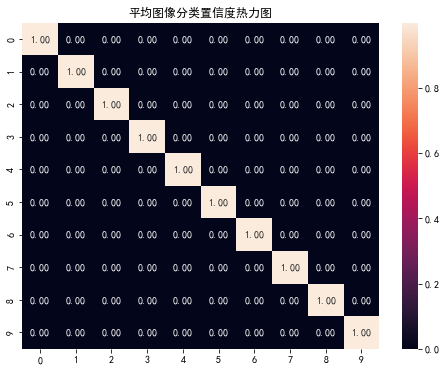

Load  VGG11_cifar


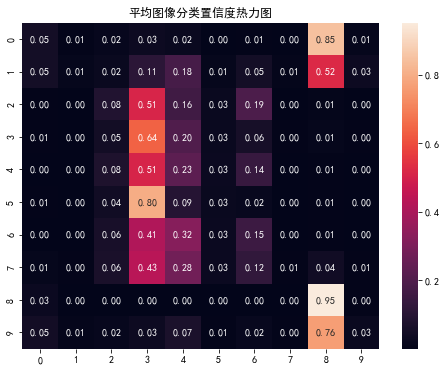

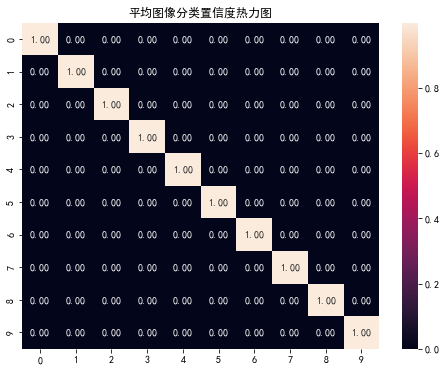

Load  ResNet18_cifar


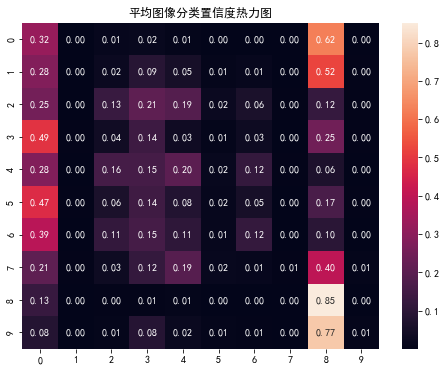

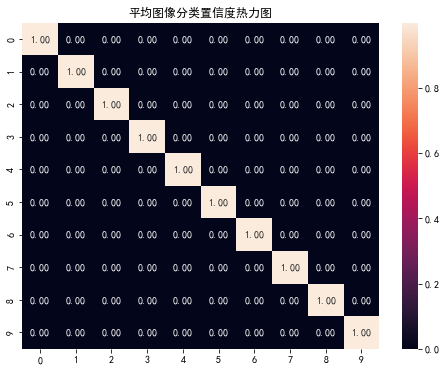

Load  AlexNet_mnist


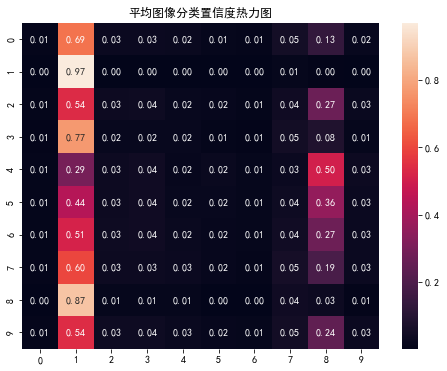

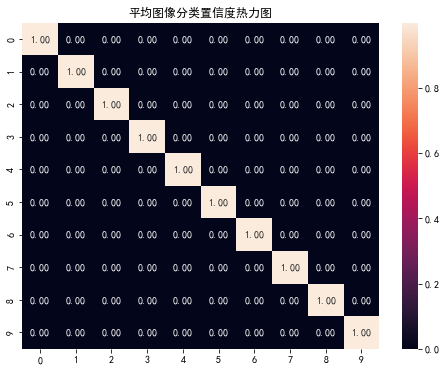

Load  VGG11_mnist


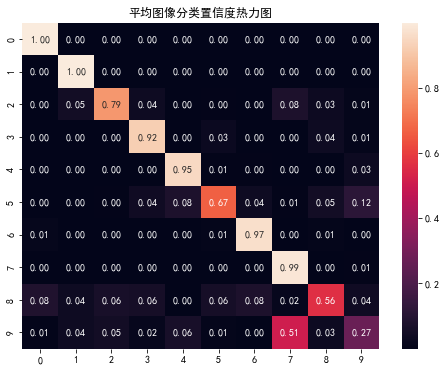

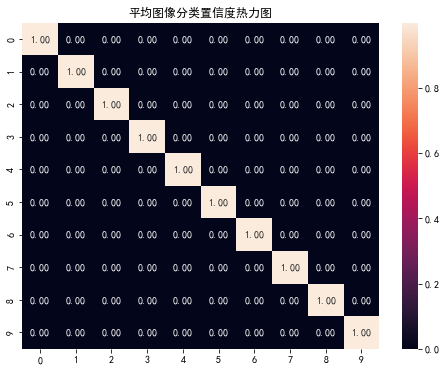

Load  ResNet18_mnist


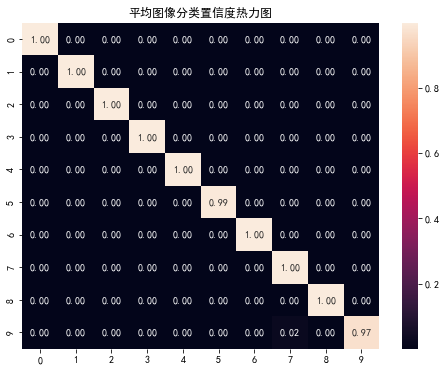

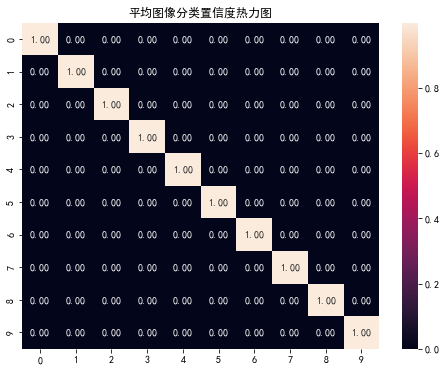

In [11]:
model_name_list = ['AlexNet_imagenet','VGG11_imagenet','ResNet18_imagenet',
                   'AlexNet_cifar','VGG11_cifar','ResNet18_cifar',
                  'AlexNet_mnist','VGG11_mnist','ResNet18_mnist']
for model_i in range(len(model_name_list)):
    model = load_pretrained_model(model_name_list[model_i].lower())
    model.eval()
    ave_data = load_ave_data(ave_data_list[model_i]+'_ave_data', path='./data')
    
    ave_data_result = test_ave_data(ave_data, model)
    plt.figure(figsize=(8, 6))
    sns.heatmap(ave_data_result, annot=True, fmt='.2f')
    plt.title('平均图像分类置信度热力图')
    plt.show()
        
    maximized_ave_data = load_ave_data('maximized_'+model_name_list[model_i].lower()+'_ave_data', path='./data')   
    maximized_data_result = test_ave_data(maximized_ave_data, model)
    plt.figure(figsize=(8, 6))
    sns.heatmap(maximized_data_result, annot=True, fmt='.2f')
    plt.title('平均图像分类置信度热力图')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

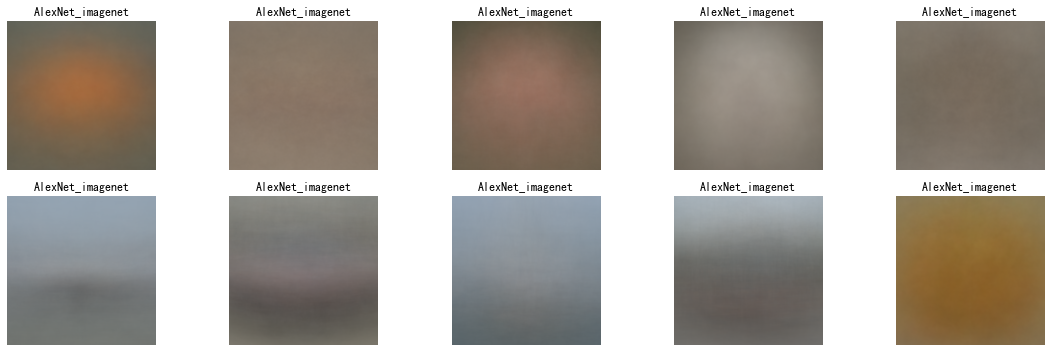

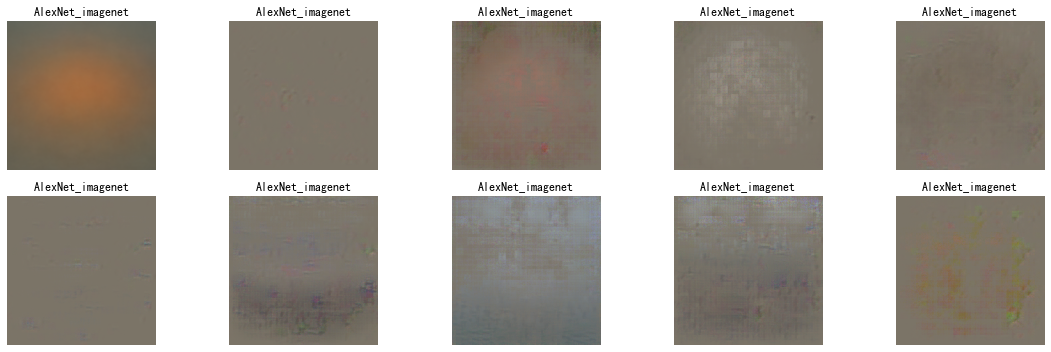

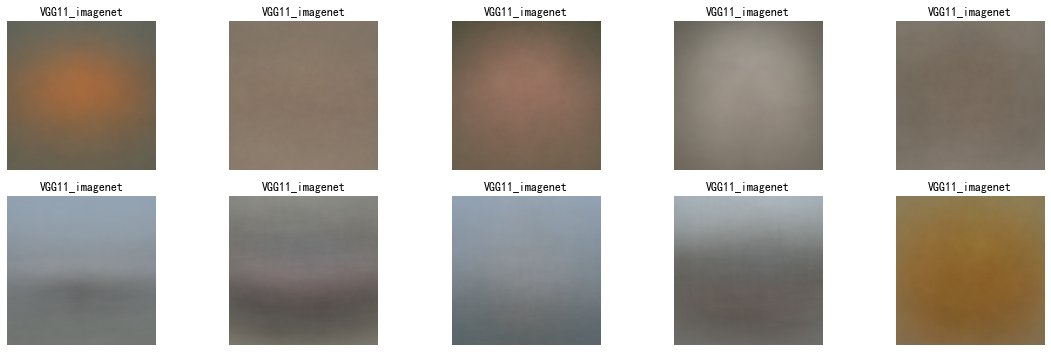

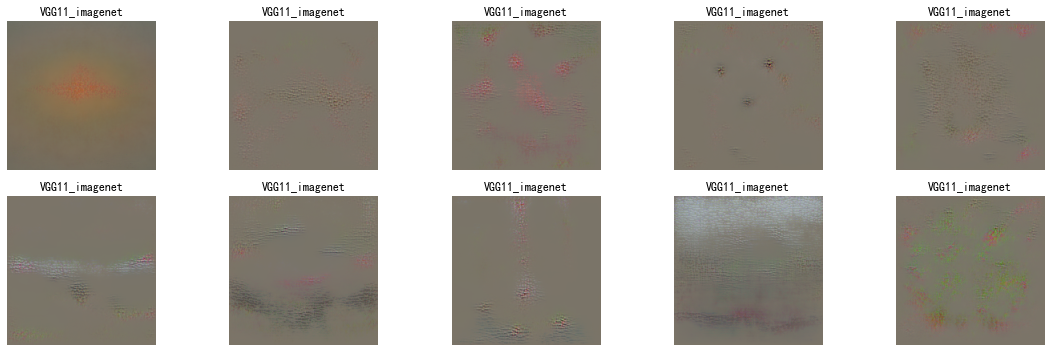

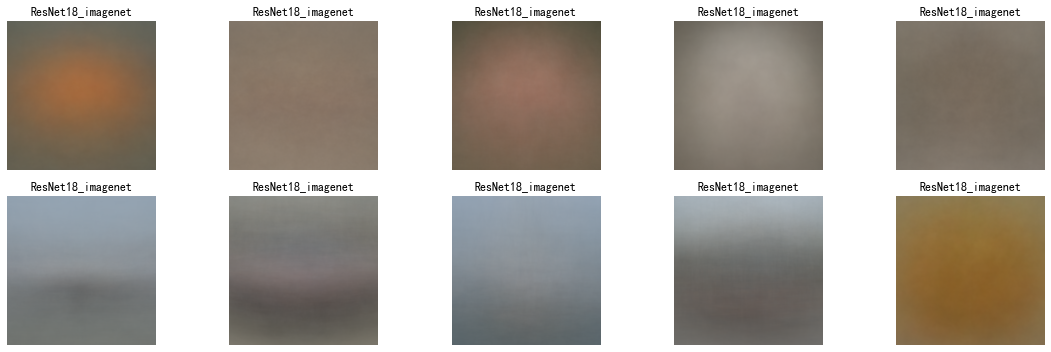

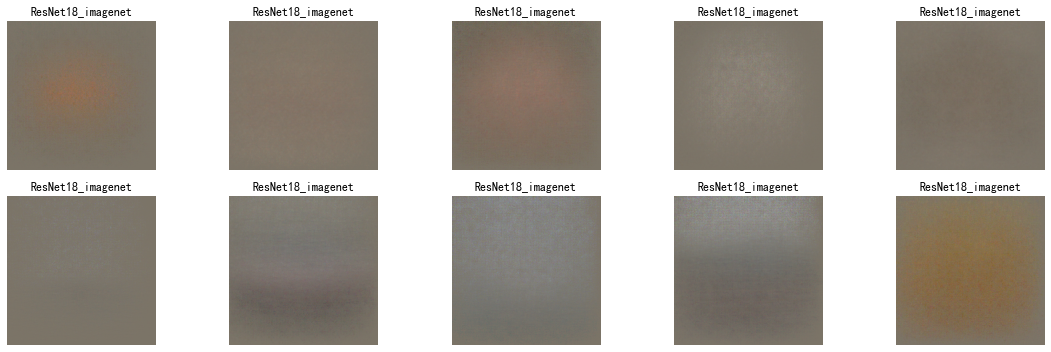

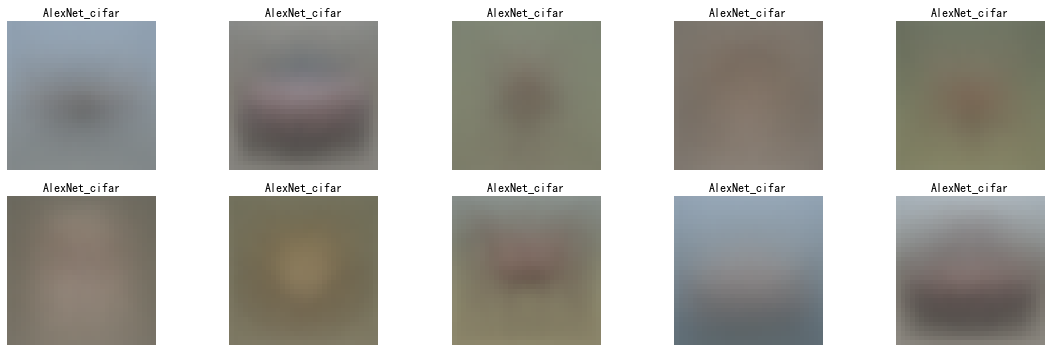

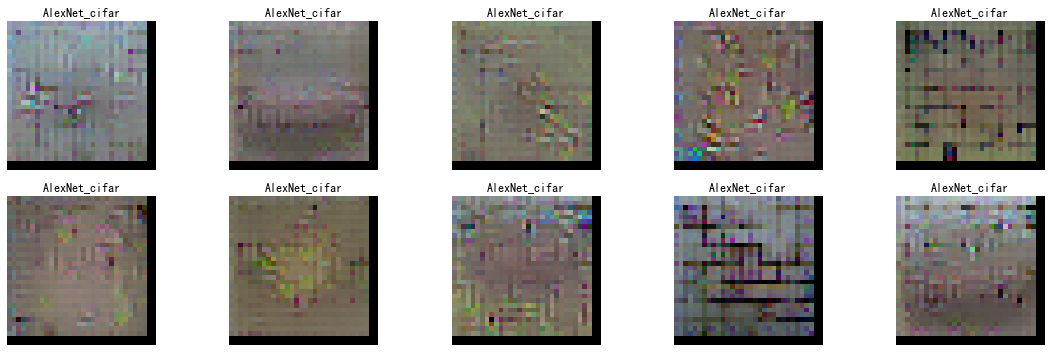

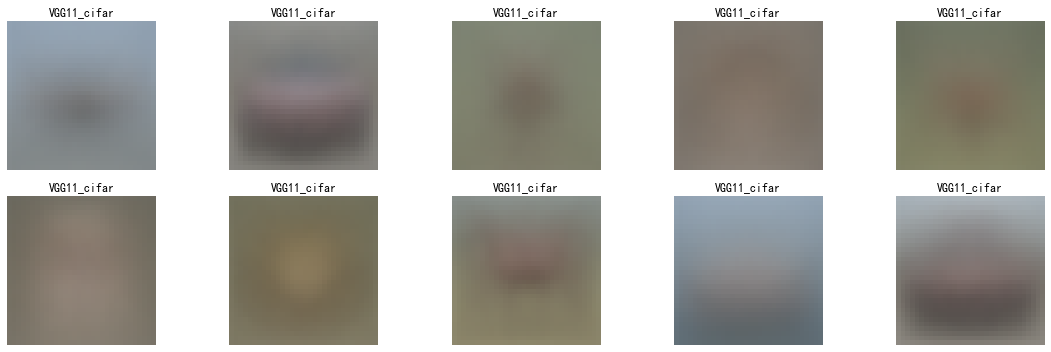

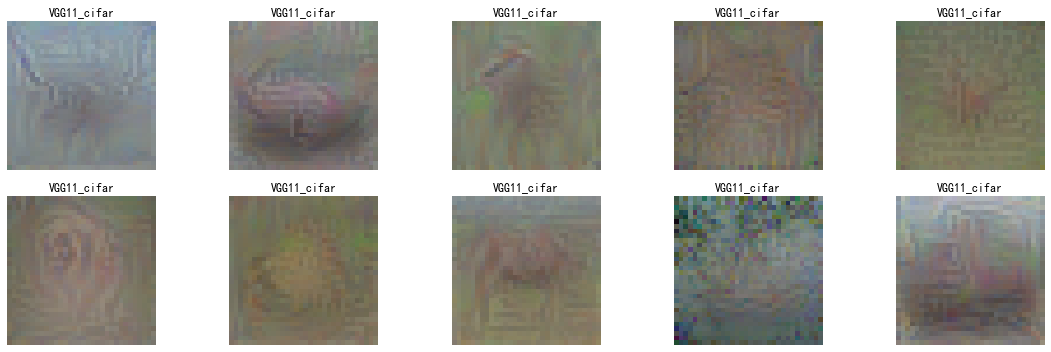

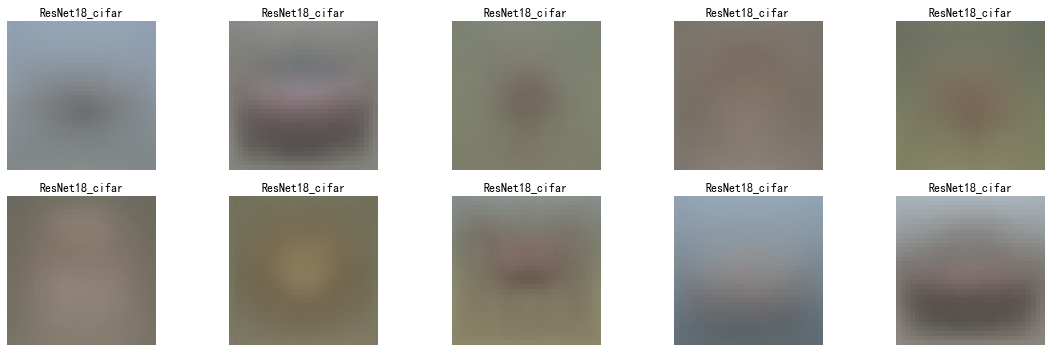

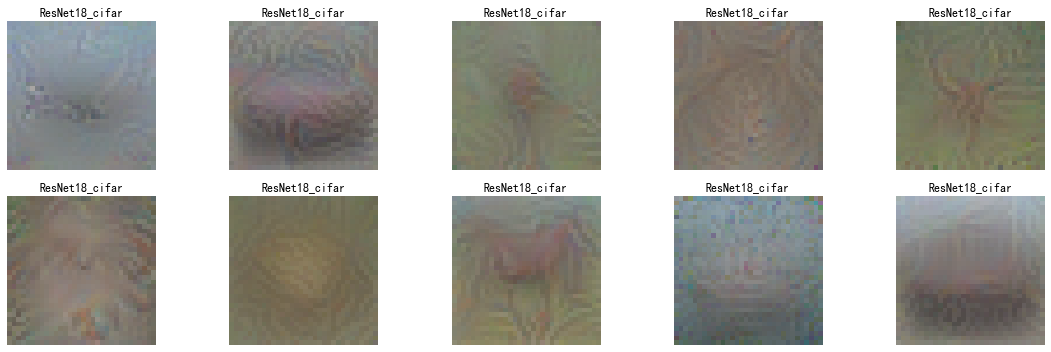

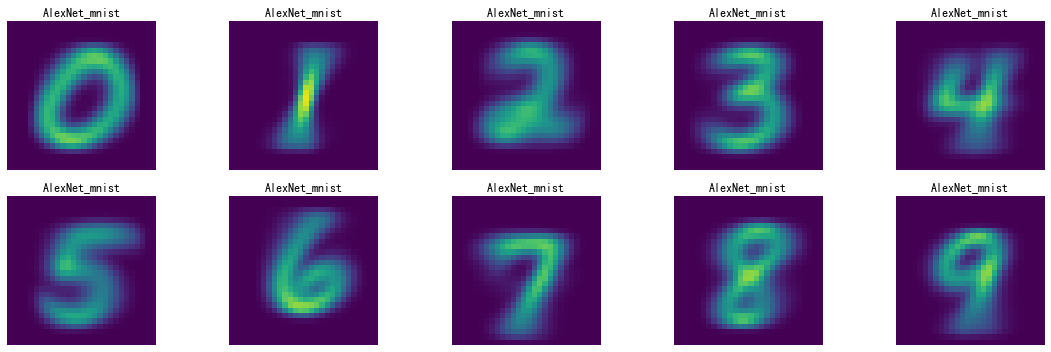

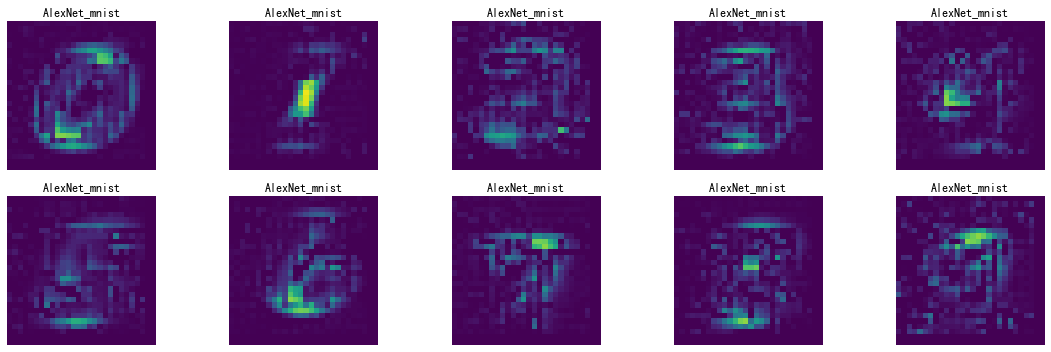

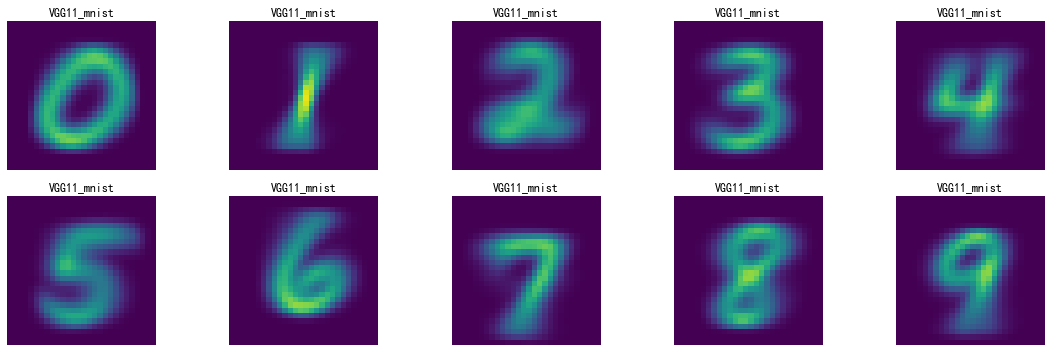

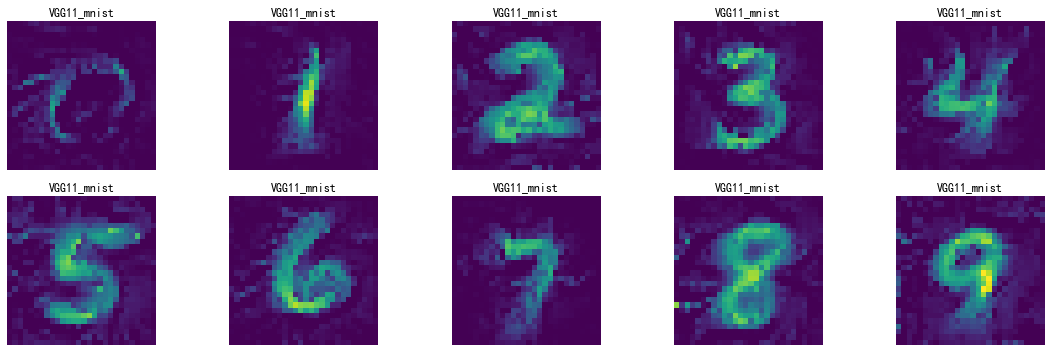

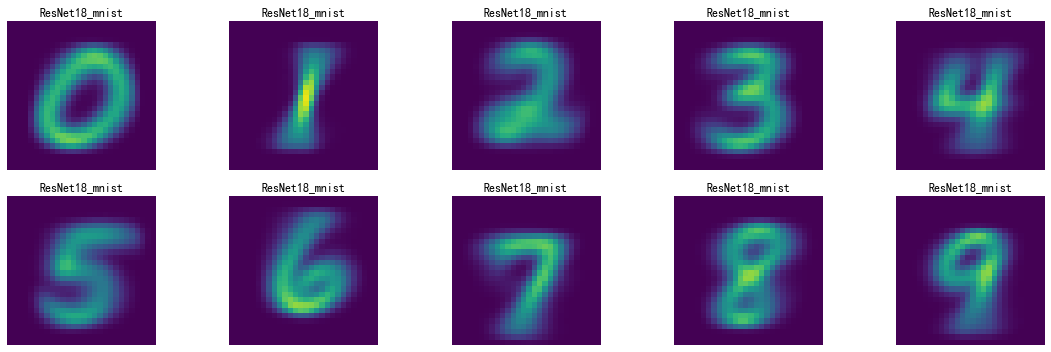

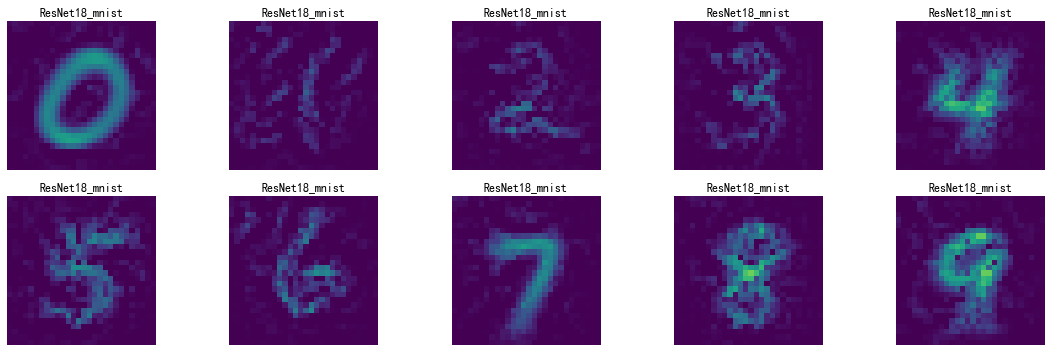

In [7]:
model_name_list = ['AlexNet_imagenet','VGG11_imagenet','ResNet18_imagenet',
                   'AlexNet_cifar','VGG11_cifar','ResNet18_cifar',
                  'AlexNet_mnist','VGG11_mnist','ResNet18_mnist']
ave_data_list = ['imagenet']*3+['cifar']*3+['mnist']*3
for model_i in range(len(model_name_list)):
    ave_data = load_ave_data(ave_data_list[model_i]+'_ave_data', path='./data')
    figure, axes = plt.subplots(2, 5, figsize=(16, 5), tight_layout=True)
    inv = True if ave_data_list[model_i]=='imagenet' else False
    for i in range(10):
        show_img((torch.from_numpy(ave_data[i])), title=model_name_list[model_i], inv=inv, transpose=True, axis=axes[i//5][i-i//5*5])
        
    maximized_ave_data = load_ave_data('maximized_'+model_name_list[model_i].lower()+'_ave_data', path='./data')    
    figure, axes = plt.subplots(2, 5, figsize=(16, 5), tight_layout=True)
    for i in range(10):
        show_img((torch.from_numpy(maximized_ave_data[i])), title=model_name_list[model_i], inv=inv if model_i<3 else False, 
                     transpose=True, axis=axes[i//5][i-i//5*5])

# ImageNet

In [10]:
model_name_list = ['AlexNet_imagenet','VGG11_imagenet','ResNet18_imagenet']
model = load_pretrained_model(model_name_list[0].lower())
ave_data = load_ave_data('imagenet_ave_data', path='./data')
result = test_ave_data(ave_data, model)

Load  AlexNet_imagenet
[[ 1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]]
[[ 0.719  0.249  0.001  0.009  0.000  0.004  0.000  0.018  0.000  0.000]]
[[ 0.613  0.374  0.001  0.010  0.001  0.001  0.000  0.000  0.000  0.000]]
[[ 0.083  0.848  0.008  0.042  0.000  0.016  0.000  0.002  0.000  0.000]]
[[ 0.328  0.658  0.000  0.012  0.001  0.000  0.000  0.000  0.000  0.001]]
[[ 0.039  0.002  0.006  0.000  0.000  0.779  0.000  0.173  0.000  0.000]]
[[ 0.034  0.491  0.014  0.005  0.015  0.232  0.004  0.193  0.003  0.009]]
[[ 0.023  0.002  0.014  0.000  0.000  0.805  0.000  0.156  0.000  0.000]]
[[ 0.366  0.028  0.027  0.000  0.000  0.433  0.000  0.138  0.007  0.001]]
[[ 0.083  0.425  0.019  0.178  0.018  0.010  0.001  0.006  0.001  0.258]]


In [59]:
import matplotlib
print(matplotlib.get_backend())
 
# Import packages
import os
print(matplotlib.get_backend())
import urllib
print(matplotlib.get_backend())
import requests
print(matplotlib.get_backend())
import math
print(matplotlib.get_backend())
import matplotlib
print(matplotlib.get_backend())
import matplotlib.pyplot as plt
print(matplotlib.get_backend())
import seaborn as sns
print(matplotlib.get_backend())
import pandas as pd
print(matplotlib.get_backend())



module://matplotlib_inline.backend_inline
module://matplotlib_inline.backend_inline
module://matplotlib_inline.backend_inline
module://matplotlib_inline.backend_inline
module://matplotlib_inline.backend_inline
module://matplotlib_inline.backend_inline
module://matplotlib_inline.backend_inline
module://matplotlib_inline.backend_inline
module://matplotlib_inline.backend_inline


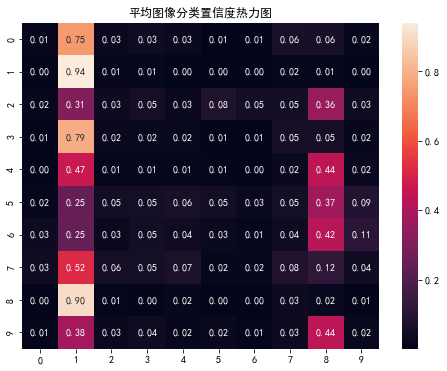

In [63]:
plt.figure(figsize=(8, 6))
sns.heatmap(result, annot=True, fmt='.2f')
plt.title('平均图像分类置信度热力图')
plt.show()

In [19]:
maximized_ave_data = ave_data_max_activation(ave_data, model, steps=10000, learning_rate=1e-3)

Target class: 0
step:0 loss:0.0000007 logit:14.5803728
min loss:0.0000007
Target class: 1
step:0 loss:0.2804839 logit:2.3216815
step:100 loss:0.0138143 logit:5.4661164
step:200 loss:0.0042256 logit:5.9706998
step:300 loss:0.0004484 logit:7.8662171
step:400 loss:0.0000600 logit:8.5331287
step:500 loss:0.0012706 logit:6.5669093
step:600 loss:0.0001879 logit:8.8547983
step:700 loss:0.0001677 logit:8.7043161
step:800 loss:0.0012714 logit:7.1640363
step:900 loss:0.0001963 logit:7.7357945
step:1000 loss:0.0002056 logit:7.7904673
step:1100 loss:0.0000538 logit:9.2996511
step:1200 loss:0.0001346 logit:7.9419947
step:1300 loss:0.0000259 logit:9.4303837
step:1400 loss:0.0001721 logit:7.8418503
step:1500 loss:0.0001863 logit:8.6758404
step:1600 loss:0.0001175 logit:8.8750296
step:1700 loss:0.0000423 logit:9.5752420
step:1800 loss:0.0001160 logit:8.4858894
step:1900 loss:0.0000360 logit:9.3631973
min loss:0.0000008
Target class: 2
step:0 loss:6.0816379 logit:-2.0320470
step:100 loss:0.0433340 logi

step:3100 loss:0.0006360 logit:7.0795107
step:3200 loss:0.0000520 logit:9.2697487
min loss:0.0000004
Target class: 7
step:0 loss:1.4149910 logit:1.3200028
step:100 loss:0.0888742 logit:2.9246020
step:200 loss:0.0177665 logit:5.6864781
step:300 loss:0.0015238 logit:7.5516376
step:400 loss:0.0269682 logit:4.6400485
step:500 loss:0.0118073 logit:4.3820896
step:600 loss:0.0020602 logit:6.7834396
step:700 loss:0.0012657 logit:7.9872408
step:800 loss:0.0036692 logit:7.1048722
step:900 loss:0.0002813 logit:9.2064066
step:1000 loss:0.0000178 logit:10.4422865
step:1100 loss:0.0000250 logit:10.7815485
step:1200 loss:0.0020650 logit:6.8110566
step:1300 loss:0.0006795 logit:8.7577066
step:1400 loss:0.0000339 logit:10.6702843
min loss:0.0000002
Target class: 8
step:0 loss:5.8794079 logit:-4.4263082
step:100 loss:0.2151942 logit:1.2760446
step:200 loss:0.0196657 logit:3.2135129
step:300 loss:0.0194219 logit:3.2429993
step:400 loss:0.0535682 logit:2.8818159
step:500 loss:0.0221209 logit:2.7545333
ste

Load  AlexNet_imagenet
[[ 1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]]
[[ 0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]]
[[ 0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]]
[[ 0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000]]
[[ 0.000  0.000  0.000  0.000  0.999  0.000  0.000  0.000  0.000  0.000]]
[[ 0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000]]
[[ 0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000]]
[[ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000]]
[[ 0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000  0.998  0.000]]
[[ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000]]


Text(0.5, 1.0, '平均图像分类置信度热力图')

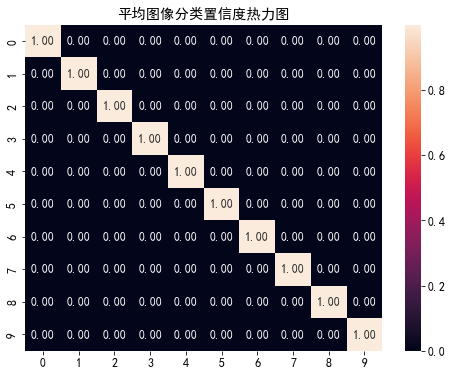

In [21]:
model_name_list = ['AlexNet_imagenet','VGG11_imagenet','ResNet18_imagenet']
model = load_pretrained_model(model_name_list[0].lower())
result = test_ave_data(maximized_ave_data, model)

f, ax = plt.subplots(figsize=(8, 6),nrows=1)
sns.heatmap(result, annot=True, fmt='.2f', ax=ax)
ax.set_title('平均图像分类置信度热力图')

In [21]:
np.save('./data/imagenet_maximized_ave_data.npy', maximized_ave_data)

ImageNet:  (10, 3, 224, 224)


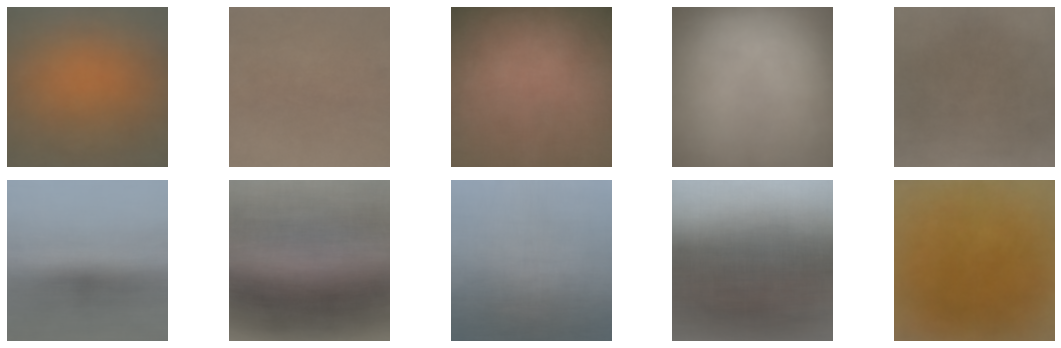

In [30]:
import matplotlib.pyplot as plt
from utils import show_img
import torch
import numpy as np
ave_data = np.load('./data/imagenet_ave_data.npy', allow_pickle=True)
print('ImageNet: ',ave_data.shape)
figure, axes = plt.subplots(2, 5, figsize=(16, 5), tight_layout=True)
for i in range(10):
    show_img((torch.from_numpy(ave_data[i])), inv=True, transpose=True, axis=axes[i//5][i-i//5*5])

ImageNet:  (10, 3, 224, 224)


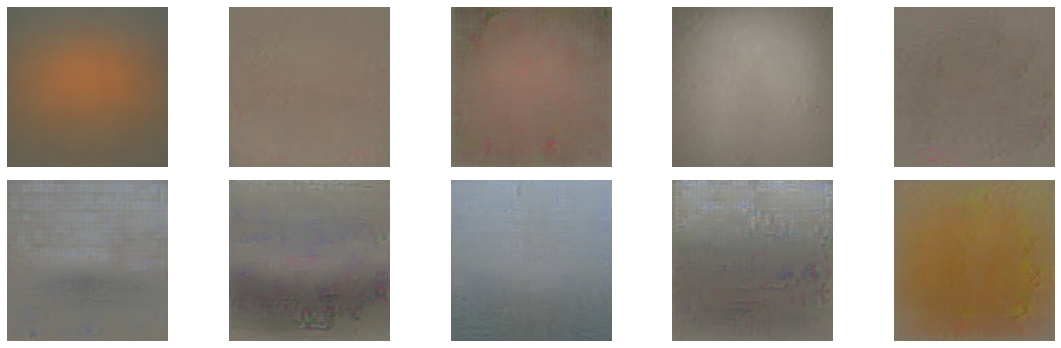

In [22]:
v

In [34]:
['imagenet']*3+['cifar']*3+['mnist']*3

['imagenet',
 'imagenet',
 'imagenet',
 'cifar',
 'cifar',
 'cifar',
 'mnist',
 'mnist',
 'mnist']

# CIFAR-10

In [22]:
model_name_list = ['AlexNet_cifar','VGG11_cifar','ResNet18_cifar']
model = load_pretrained_model(model_name_list[0].lower())
ave_data = load_ave_data('cifar_ave_data', path='./data')
result = test_ave_data(ave_data, model)

Load  AlexNet_cifar
[[ 0.169  0.035  0.016  0.013  0.014  0.003  0.006  0.001  0.696  0.045]]
[[ 0.104  0.076  0.087  0.149  0.059  0.082  0.066  0.040  0.252  0.084]]
[[ 0.008  0.004  0.114  0.219  0.299  0.143  0.139  0.064  0.004  0.006]]
[[ 0.011  0.006  0.118  0.289  0.197  0.185  0.116  0.062  0.009  0.008]]
[[ 0.002  0.000  0.123  0.099  0.574  0.071  0.104  0.025  0.001  0.000]]
[[ 0.014  0.005  0.156  0.216  0.255  0.151  0.116  0.070  0.008  0.009]]
[[ 0.003  0.000  0.139  0.069  0.613  0.046  0.106  0.023  0.000  0.001]]
[[ 0.016  0.003  0.198  0.153  0.325  0.117  0.102  0.073  0.006  0.007]]
[[ 0.077  0.037  0.003  0.006  0.002  0.001  0.002  0.000  0.851  0.022]]
[[ 0.146  0.146  0.059  0.073  0.044  0.034  0.049  0.019  0.307  0.123]]


Text(0.5, 1.0, '平均图像分类置信度热力图')

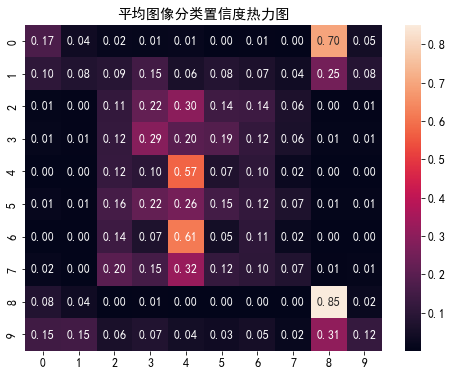

In [23]:
f, ax = plt.subplots(figsize=(8, 6),nrows=1)
sns.heatmap(result, annot=True, fmt='.2f', ax=ax)
ax.set_title('平均图像分类置信度热力图')

In [24]:
maximized_ave_data = ave_data_max_activation(ave_data, model, steps=10000, learning_rate=1e-3, save='./data/cifar_maximized_ave_data.npy')

Target class: 0
step:0 loss:2.0367074 logit:0.2993831
step:100 loss:0.5290497 logit:1.7257147
step:200 loss:0.1071027 logit:3.3639300
step:300 loss:0.0027169 logit:6.9644909
step:400 loss:0.0009435 logit:8.1153059
step:500 loss:0.0000243 logit:10.8914003
step:600 loss:0.0049866 logit:6.4508786
step:700 loss:0.0000006 logit:13.8209448
min loss:0.0000006
Target class: 1
step:0 loss:2.5400152 logit:-0.6462509
step:100 loss:0.0037875 logit:7.9740992
step:200 loss:0.0017707 logit:8.3817472
step:300 loss:0.0003943 logit:10.8282804
step:400 loss:0.0002087 logit:11.2948694
step:500 loss:0.0000873 logit:12.4785500
step:600 loss:0.0002486 logit:10.9877758
min loss:0.0000008
Target class: 2
step:0 loss:1.7531540 logit:0.5380545
step:100 loss:0.0068712 logit:6.2446442
step:200 loss:0.0196226 logit:5.2207546
step:300 loss:0.0124752 logit:5.4902835
step:400 loss:0.0592235 logit:4.1491809
step:500 loss:0.0521791 logit:4.6139655
step:600 loss:0.0096746 logit:5.8576179
step:700 loss:0.0040402 logit:10.

Load  AlexNet_cifar
[[ 0.997  0.000  0.000  0.000  0.002  0.000  0.000  0.000  0.000  0.000]]
[[ 0.000  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]]
[[ 0.000  0.000  0.999  0.000  0.001  0.000  0.000  0.000  0.000  0.000]]
[[ 0.000  0.000  0.000  0.996  0.000  0.004  0.000  0.000  0.000  0.000]]
[[ 0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000]]
[[ 0.000  0.000  0.000  0.001  0.000  0.999  0.000  0.000  0.000  0.000]]
[[ 0.000  0.000  0.000  0.001  0.001  0.000  0.998  0.000  0.000  0.000]]
[[ 0.000  0.000  0.000  0.000  0.001  0.000  0.000  0.999  0.000  0.000]]
[[ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000]]
[[ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000]]


Text(0.5, 1.0, '平均图像分类置信度热力图')

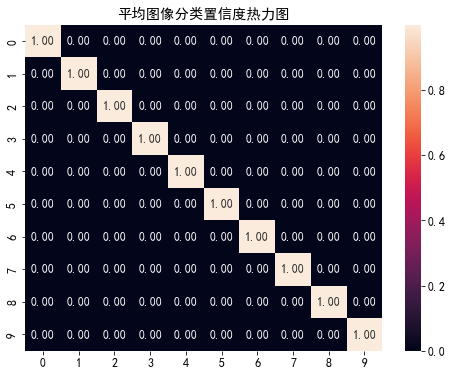

In [25]:
maximized_ave_data = np.load('./data/cifar_maximized_ave_data.npy', allow_pickle=True)

model_name_list = ['AlexNet_cifar','VGG11_cifar','ResNet18_cifar']
model = load_pretrained_model(model_name_list[0].lower())
result = test_ave_data(maximized_ave_data, model)

f, ax = plt.subplots(figsize=(8, 6),nrows=1)
sns.heatmap(result, annot=True, fmt='.2f', ax=ax)
ax.set_title('平均图像分类置信度热力图')

ImageNet:  (10, 3, 32, 32)


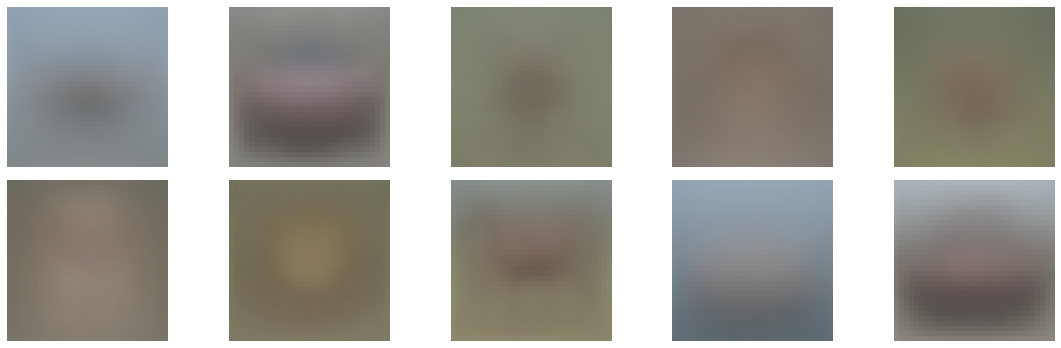

In [35]:
import matplotlib.pyplot as plt
from utils import show_img
import torch
import numpy as np
ave_data = np.load('./data/cifar_ave_data.npy', allow_pickle=True)
print('ImageNet: ',ave_data.shape)
figure, axes = plt.subplots(2, 5, figsize=(16, 5), tight_layout=True)
for i in range(10):
    show_img((torch.from_numpy(ave_data[i])), inv=False, transpose=True, axis=axes[i//5][i-i//5*5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ImageNet:  (10, 3, 32, 32)


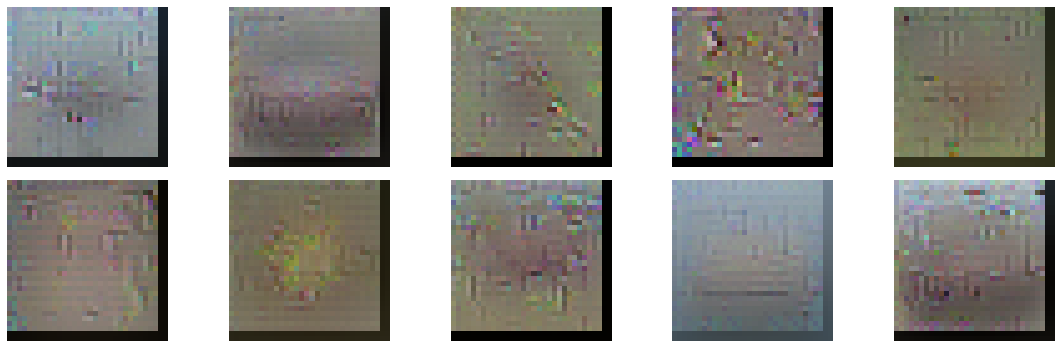

In [38]:
import matplotlib.pyplot as plt
from utils import show_img
import torch
import numpy as np
ave_data = np.load('./data/maximized_cifar_alexnet_ave_data.npy', allow_pickle=True)
print('ImageNet: ',ave_data.shape)
figure, axes = plt.subplots(2, 5, figsize=(16, 5), tight_layout=True)
for i in range(10):
    show_img((torch.from_numpy(ave_data[i])), inv=False, transpose=True, axis=axes[i//5][i-i//5*5])

# MNIST

Load  AlexNet_mnist
[[ 0.012  0.745  0.028  0.035  0.028  0.008  0.007  0.062  0.056  0.019]]
[[ 0.001  0.941  0.011  0.012  0.003  0.002  0.001  0.016  0.012  0.002]]
[[ 0.018  0.310  0.032  0.053  0.029  0.077  0.045  0.046  0.357  0.034]]
[[ 0.007  0.787  0.024  0.022  0.022  0.007  0.007  0.055  0.054  0.016]]
[[ 0.002  0.465  0.009  0.011  0.013  0.009  0.003  0.023  0.439  0.025]]
[[ 0.015  0.250  0.048  0.049  0.060  0.047  0.025  0.051  0.370  0.086]]
[[ 0.033  0.246  0.028  0.045  0.037  0.030  0.013  0.036  0.424  0.107]]
[[ 0.034  0.517  0.056  0.049  0.069  0.016  0.018  0.078  0.117  0.045]]
[[ 0.002  0.901  0.008  0.005  0.018  0.002  0.003  0.032  0.022  0.007]]
[[ 0.009  0.381  0.026  0.040  0.016  0.025  0.012  0.031  0.437  0.023]]


C:\Users\wangx\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


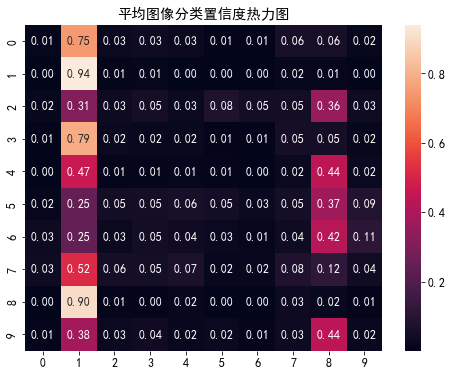

In [52]:
model_name_list = ['AlexNet_mnist','VGG11_mnist','ResNet18_mnist']
model = load_pretrained_model(model_name_list[0].lower())
ave_data = load_ave_data('mnist_ave_data', path='./data')
result = test_ave_data(ave_data, model)

f, ax = plt.subplots(figsize=(8, 6),nrows=1)
sns.heatmap(result, annot=True, fmt='.2f', ax=ax)
ax.set_title('平均图像分类置信度热力图')
f.show()

In [27]:
maximized_ave_data = ave_data_max_activation(ave_data, model, steps=10000, learning_rate=1e-3, save='./data/mnist_maximized_ave_data.npy')

Target class: 0
step:0 loss:4.7321334 logit:-3.4902933
step:100 loss:0.1187696 logit:1.8209473
step:200 loss:0.0019993 logit:4.6646490
min loss:0.0000001
Target class: 1
step:0 loss:0.0277276 logit:2.4026358
min loss:0.0000006
Target class: 2
step:0 loss:3.2075257 logit:-2.0748701
step:100 loss:3.4569268 logit:-2.4167964
step:200 loss:2.3022060 logit:-1.1735415
step:300 loss:2.9156842 logit:-2.0463791
step:400 loss:2.8536708 logit:-1.9221026
step:500 loss:2.4722624 logit:-1.3024267
step:600 loss:2.1584809 logit:-1.1610719
step:700 loss:2.3229325 logit:-1.2160639
step:800 loss:3.0778565 logit:-2.0199621
step:900 loss:2.2032785 logit:-0.9260075
step:1000 loss:2.0077066 logit:-0.7840921
step:1100 loss:1.8396742 logit:-0.8525879
step:1200 loss:2.0355222 logit:-0.9806553
step:1300 loss:2.2599418 logit:-1.1022934
step:1400 loss:1.6377512 logit:-0.5857656
step:1500 loss:2.0704799 logit:-0.9447715
step:1600 loss:0.2615529 logit:1.3211076
step:1700 loss:0.0038460 logit:3.9903922
step:1800 loss:

Load  AlexNet_mnist
[[ 0.997  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.001  0.001]]
[[ 0.000  0.997  0.001  0.000  0.000  0.000  0.000  0.001  0.000  0.000]]
[[ 0.000  0.000  0.990  0.001  0.000  0.000  0.000  0.008  0.000  0.000]]
[[ 0.000  0.000  0.000  0.999  0.000  0.000  0.000  0.000  0.000  0.000]]
[[ 0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000  0.000]]
[[ 0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000  0.000]]
[[ 0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000  0.000]]
[[ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000  0.000]]
[[ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000  0.000]]
[[ 0.001  0.000  0.002  0.002  0.009  0.010  0.000  0.001  0.002  0.973]]


Text(0.5, 1.0, '平均图像分类置信度热力图')

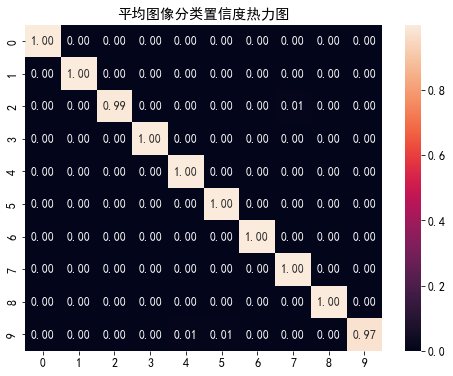

In [33]:
model_name_list = ['AlexNet_mnist','VGG11_mnist','ResNet18_mnist']
model = load_pretrained_model(model_name_list[0].lower())
ave_data = load_ave_data('mnist_maximized_ave_data', path='./data')
result = test_ave_data(ave_data, model)

f, ax = plt.subplots(figsize=(8, 6),nrows=1)
sns.heatmap(result, annot=True, fmt='.2f', ax=ax)
ax.set_title('平均图像分类置信度热力图')

MNIST:  (10, 1, 28, 28)


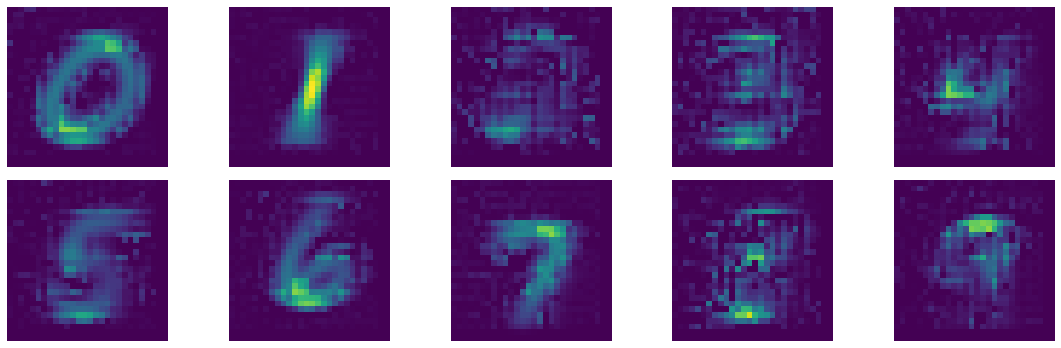

In [29]:
import matplotlib.pyplot as plt
from utils import show_img
import torch
import numpy as np
ave_data = np.load('./data/mnist_maximized_ave_data.npy', allow_pickle=True)
print('MNIST: ',ave_data.shape)
figure, axes = plt.subplots(2, 5, figsize=(16, 5), tight_layout=True)
for i in range(10):
    show_img(ave_data[i], transpose=True, axis=axes[i//5][i-i//5*5])

# 结论  
直接对数据集平均化，图像模糊，并且输入到网络中并不是所属类的分类置信度最高，这可能是过去实验中相似值对类别不敏感的原因之一（还有导向反向传播本身的原因）。类内方差小的平均图所需的最大化步数少，结果更清晰，语义信息更明显。最大化添加的是网络对应的低频信息，肉眼难以理解。最大激活做的是在一个输入图像I上进行梯度下降，直到到达损失函数的局部最低点，因此作为优化初始的输入图像很关键，过去常用的方法是在数据集种选择激活值最大的topk做优化，但是这样基于单张图像的优化，更容易陷入局部最优，因此使用平均图更好一点。接下来的问题就是如何设计相似值比较的两个数据，如果一个是最大激活的平均图的话。